In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cycler
from scipy import stats
import statsmodels.api as sm

In [2]:
df = pd.read_csv('df1.csv')
df

,year,vwretd,vwretx,vwRetd,vwRetx,rf,Rf,DP,DG
0,1926,0.098479,0.043034,1.098479,1.043034,0.0351,1.0351,0.053157,NaN
1,1927,0.328716,0.266477,1.328716,1.266477,0.0307,1.0307,0.049143,1.170843
2,1928,0.391397,0.337056,1.391397,1.337056,0.0317,1.0317,0.040642,1.105764
3,1929,-0.150955,-0.182395,0.849045,0.817605,0.0426,1.0426,0.038454,0.773579
4,1930,-0.289005,-0.321455,0.710995,0.678545,0.0303,1.0303,0.047823,0.843870
...,...,...,...,...,...,...,...,...,...
89,2015,-0.015995,-0.037069,0.984005,0.962931,0.0003,1.0003,0.021885,1.008804
90,2016,0.129461,0.104250,1.129461,1.104250,0.0023,1.0023,0.022831,1.151962
91,2017,0.209028,0.184488,1.209028,1.184488,0.0051,1.0051,0.020718,1.074860
92,2018,-0.061828,-0.081145,0.938172,0.918855,0.0132,1.0132,0.021023,0.932386


In [3]:
# Although in this analysis, DG1926=nan does not matter, Zhiwen suggests delete the observations where nan appears 
# and keep the sample balanced
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
df

,year,vwretd,vwretx,vwRetd,vwRetx,rf,Rf,DP,DG
0,1927,0.328716,0.266477,1.328716,1.266477,0.0307,1.0307,0.049143,1.170843
1,1928,0.391397,0.337056,1.391397,1.337056,0.0317,1.0317,0.040642,1.105764
2,1929,-0.150955,-0.182395,0.849045,0.817605,0.0426,1.0426,0.038454,0.773579
3,1930,-0.289005,-0.321455,0.710995,0.678545,0.0303,1.0303,0.047823,0.843870
4,1931,-0.443873,-0.476969,0.556127,0.523031,0.0148,1.0148,0.063277,0.692053
...,...,...,...,...,...,...,...,...,...
88,2015,-0.015995,-0.037069,0.984005,0.962931,0.0003,1.0003,0.021885,1.008804
89,2016,0.129461,0.104250,1.129461,1.104250,0.0023,1.0023,0.022831,1.151962
90,2017,0.209028,0.184488,1.209028,1.184488,0.0051,1.0051,0.020718,1.074860
91,2018,-0.061828,-0.081145,0.938172,0.918855,0.0132,1.0132,0.021023,0.932386


In [4]:
df['dp'] = np.log(df['DP'])
df['dg'] = np.log(df['DG'])
df['r'] = np.log(df['vwRetd'])

In [5]:
rho = np.exp(- df['dp'].mean()) / (1 + np.exp(- df['dp'].mean()))
rho

0.9669445703655455

### back-out approach

In [6]:
# Dependent variable (nparray)
Y = np.array(df.loc[1:, 'r'])[:, np.newaxis]
# Independent variables (nparray)
X = np.array(df.loc[:df.shape[0] - 2, ['r', 'dp']]) # .loc will include the tail!!!!!!!!!!
X = sm.add_constant(X)
model = sm.OLS(Y, X)
result1 = model.fit()

In [7]:
# Dependent variable (nparray)
Y = np.array(df.loc[1:, 'dp'])[:, np.newaxis]
# Independent variables (nparray)
X = np.array(df.loc[:df.shape[0] - 2, ['r', 'dp']]) # .loc will include the tail!!!!!!!!!!
X = sm.add_constant(X)
model = sm.OLS(Y, X)
result2 = model.fit()

In [8]:
A = np.array([[result1.params[1], result1.params[2]],
              [result2.params[1], result2.params[2]]])

In [9]:
A

array([[ 0.05115561,  0.08138266],
       [-0.21012145,  0.94108959]])

In [10]:
e1 = np.array([1, 0])
e1G = e1 @ np.linalg.inv(np.identity(2) - rho * A) @ A
print('e1G:',  e1G)

e1G: [-0.11747454  0.80137161]


In [11]:
df['dpr'] = np.array(df[['r', 'dp']]) @ e1G[:, np.newaxis]
df['dpd_indirect'] = df['dpr'] - df['dp']

### direct approach

In [12]:
# Dependent variable (nparray)
Y = np.array(df.loc[1:, 'dg'])[:, np.newaxis]
# Independent variables (nparray)
X = np.array(df.loc[:df.shape[0] - 2, ['r', 'dp']]) # .loc will include the tail!!!!!!!!!!
X = sm.add_constant(X)
model = sm.OLS(Y, X)
result3 = model.fit()
b = result3.params[1:3]

In [13]:
b

array([-0.14865801, -0.00771626])

In [14]:
df['dpd_direct'] = np.array(df[['r', 'dp']]) @ (b @ np.linalg.inv(np.identity(2) - rho * A))[:, np.newaxis]

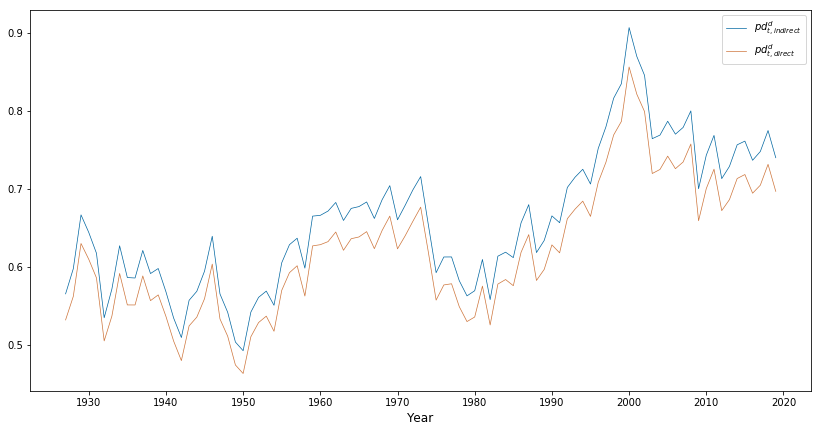

In [15]:
# ax will be an array of Axes objects
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_prop_cycle(cycler('color', ['#0066a1', '#ce753b', '#b85696', '#31686c', '#853c42']))

# Call plot() method on the appropriate object
ax.plot(df['year'], df['dpd_indirect'], linewidth=0.7, label=r'$pd_{t, indirect}^{d}$')
ax.plot(df['year'], df['dpd_direct'], linewidth=0.7, label=r'$pd^d_{t, direct}$')

ax.set_xlabel('Year', fontsize = 12)
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.legend();

In [18]:
fig.savefig('q2fig1.eps', format = 'eps')

### Other state variables

In [19]:
df = pd.read_csv('df2.csv')
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
df['dp'] = np.log(df['DP'])
df['dg'] = np.log(df['DG'])
df['r'] = np.log(df['vwRetd'])
df['term'] = (df['lty'] - df['tbl']) * 100
df['def'] = (df['BAA'] - df['AAA']) * 100
df

,year,vwretd,vwretx,vwRetd,vwRetx,rf,AAA,BAA,tbl,lty,Rf,DP,DG,dp,dg,r,term,def
0,1927,0.328716,0.266477,1.328716,1.266477,0.0307,0.0446,0.0532,0.0317,0.0316,1.0307,0.049143,1.170843,-3.013012,0.157724,0.284213,-0.01,0.86
1,1928,0.391397,0.337056,1.391397,1.337056,0.0317,0.0461,0.0560,0.0426,0.0340,1.0317,0.040642,1.105764,-3.202946,0.100536,0.330308,-0.86,0.99
2,1929,-0.150955,-0.182395,0.849045,0.817605,0.0426,0.0467,0.0595,0.0303,0.0340,1.0426,0.038454,0.773579,-3.258298,-0.256728,-0.163643,0.37,1.28
3,1930,-0.289005,-0.321455,0.710995,0.678545,0.0303,0.0452,0.0671,0.0148,0.0330,1.0303,0.047823,0.843870,-3.040250,-0.169756,-0.341090,1.82,2.19
4,1931,-0.443873,-0.476969,0.556127,0.523031,0.0148,0.0532,0.1042,0.0241,0.0407,1.0148,0.063277,0.692053,-2.760228,-0.368092,-0.586759,1.66,5.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,2015,-0.015995,-0.037069,0.984005,0.962931,0.0003,0.0397,0.0546,0.0023,0.0243,1.0003,0.021885,1.008804,-3.821942,0.008766,-0.016124,2.20,1.49
89,2016,0.129461,0.104250,1.129461,1.104250,0.0023,0.0406,0.0483,0.0051,0.0272,1.0023,0.022831,1.151962,-3.779641,0.141467,0.121741,2.21,0.77
90,2017,0.209028,0.184488,1.209028,1.184488,0.0051,0.0351,0.0422,0.0132,0.0254,1.0051,0.020718,1.074860,-3.876761,0.072190,0.189817,1.22,0.71
91,2018,-0.061828,-0.081145,0.938172,0.918855,0.0132,0.0402,0.0513,0.0237,0.0284,1.0132,0.021023,0.932386,-3.862143,-0.070008,-0.063822,0.47,1.11


In [20]:
rho = np.exp(- df['dp'].mean()) / (1 + np.exp(- df['dp'].mean()))
rho

0.9669445703655455

In [21]:
# Dependent variable (nparray)
Y = np.array(df.loc[1:, 'r'])[:, np.newaxis]
# Independent variables (nparray)
X = np.array(df.loc[:df.shape[0] - 2, ['r', 'term', 'def']]) # .loc will include the tail!!!!!!!!!!
X = sm.add_constant(X)
model = sm.OLS(Y, X)
result1 = model.fit()

# Dependent variable (nparray)
Y = np.array(df.loc[1:, 'term'])[:, np.newaxis]
# Independent variables (nparray)
X = np.array(df.loc[:df.shape[0] - 2, ['r', 'term', 'def']]) # .loc will include the tail!!!!!!!!!!
X = sm.add_constant(X)
model = sm.OLS(Y, X)
result2 = model.fit()

# Dependent variable (nparray)
Y = np.array(df.loc[1:, 'def'])[:, np.newaxis]
# Independent variables (nparray)
X = np.array(df.loc[:df.shape[0] - 2, ['r', 'term', 'def']]) # .loc will include the tail!!!!!!!!!!
X = sm.add_constant(X)
model = sm.OLS(Y, X)
result3 = model.fit()

A = np.array([[result1.params[1], result1.params[2], result1.params[3]],
              [result2.params[1], result2.params[2], result2.params[3]],
              [result3.params[1], result3.params[2], result3.params[3]]])

In [22]:
e1 = np.array([1, 0, 0])
e1G = e1 @ np.linalg.inv(np.identity(3) - rho * A) @ A
print('e1G:',  e1G)

e1G: [0.03663417 0.01786027 0.0673956 ]


In [23]:
result3.rsquared

0.530812817287265

In [24]:
df['dpr'] = np.array(df[['r', 'term', 'def']]) @ e1G[:, np.newaxis]
df['dpd_indirect'] = df['dpr'] - df['dp']

In [25]:
# Dependent variable (nparray)
Y = np.array(df.loc[1:, 'dg'])[:, np.newaxis]
# Independent variables (nparray)
X = np.array(df.loc[:df.shape[0] - 2, ['r', 'term', 'def']]) # .loc will include the tail!!!!!!!!!!
X = sm.add_constant(X)
model = sm.OLS(Y, X)
result3 = model.fit()
b = result3.params[1:4]

In [26]:
df['dpd_direct'] = np.array(df[['r', 'term', 'def']]) @ (b @ np.linalg.inv(np.identity(3) - rho * A))[:, np.newaxis]

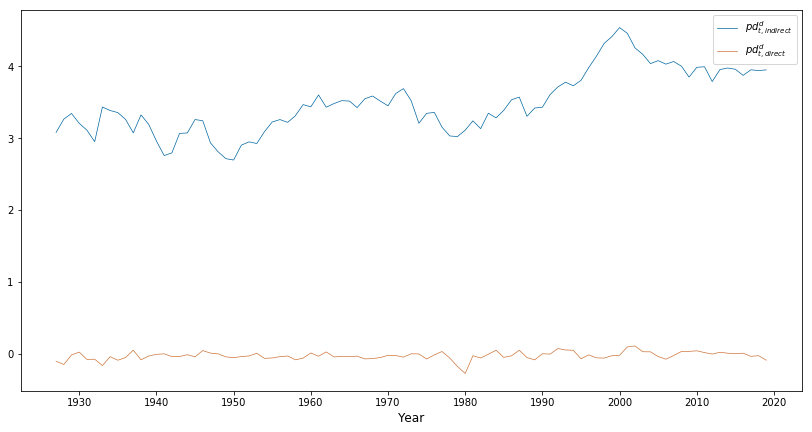

In [27]:
# ax will be an array of Axes objects
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_prop_cycle(cycler('color', ['#0066a1', '#ce753b', '#b85696', '#31686c', '#853c42']))

# Call plot() method on the appropriate object
ax.plot(df['year'], df['dpd_indirect'], linewidth=0.7, label=r'$pd_{t, indirect}^{d}$')
ax.plot(df['year'], df['dpd_direct'], linewidth=0.7, label=r'$pd^d_{t, direct}$')

ax.set_xlabel('Year', fontsize = 12)
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.legend();

In [30]:
fig.savefig('q2fig2.pdf', format = 'pdf')